### FIGURE 3

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import nglui
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
import cloudvolume
from caveclient import CAVEclient
#import pcg_skel
import tqdm
#from meshparty import meshwork
import datetime

#client = CAVEclient('minnie65_phase3_v1')
client = CAVEclient('minnie65_public')
client.info.get_datastack_info()


pd.options.display.max_rows = None
pd.options.display.max_columns = None

#Load dataframe
synapse_table = pd.read_feather("ET_extended_synapse_table_revision.feather")

In [2]:
# check duplicate entries 
duplicates = synapse_table[synapse_table['synapse_id'].duplicated(keep=False)]

print("Duplicate entries:")
print(duplicates.synapse_id.unique())

# Remove duplicate rows 

print("original synapse table size")
print(synapse_table.shape)

synapse_table = synapse_table.drop_duplicates(subset='synapse_id')

print(" synapse table size without duplicates")
print(synapse_table.shape)

Duplicate entries:
[183966021]
original synapse table size
(5530, 32)
 synapse table size without duplicates
(5525, 32)


In [3]:
# MAIN
#'y' location of cortical surface
surface_y_column =[84534, 85689, 86053, 87800, 89421, 90105, 82884, 81677, 86242]
average_surface_location = mean(surface_y_column)

In [4]:
#root IDs of ET neurons
V1_neurons_rootID = synapse_table[synapse_table['pre_soma_area'] == 'v1']['pre_pt_root_id'].unique()
HVA_neurons_rootID = synapse_table[synapse_table['pre_soma_area'] == 'hva']['pre_pt_root_id'].unique()
All_neurons_rootID = list(V1_neurons_rootID) + list(HVA_neurons_rootID)

#nucleus IDs of ET neurons
V1_neurons_nucleusID = synapse_table[synapse_table['pre_soma_area'] == 'v1']['pre_nucleus_id'].unique()
HVA_neurons_nucleusID = synapse_table[synapse_table['pre_soma_area'] == 'hva']['pre_nucleus_id'].unique()
All_neurons_nucleusID = list(V1_neurons_nucleusID) + list(HVA_neurons_nucleusID)


In [5]:
#Statistics of ET Neurons


# synaptic input to ET neurons

import statistics
import numpy

et_table = 'bodor_pt_cells'
et_df = client.materialize.query_table(et_table)

pt_rootIDs = list(et_df.pt_root_id.unique())


ET_total_inputs = []

for ii,pt_root_id in enumerate(pt_rootIDs): 

    ET_individuals = {
        'ID': pt_root_id,
        'total_inputs': len(client.materialize.synapse_query(post_ids=pt_root_id))
    }
    ET_total_inputs.append(ET_individuals)

ET_total_inputs_df = pd.DataFrame(ET_total_inputs)

print(ET_total_inputs_df)
print('mean: ', mean(ET_total_inputs_df['total_inputs'].values))
print('stdev: ', numpy.std(ET_total_inputs_df['total_inputs'].values))






                    ID  total_inputs
0   864691136974876956         14717
1   864691135273655569         11823
2   864691136578820884         12659
3   864691135397023777          9122
4   864691136578814228         13407
5   864691135517376211         11047
6   864691136991202453         15326
7   864691135489514810         26797
8   864691136579127060         11562
9   864691135503182685         11128
10  864691135339044582         10355
11  864691135464714565         10147
mean:  13174
stdev:  4468.219067916085


In [6]:
#Statistics of ET Neurons
from meshparty import meshwork


# Axon length of ET neurons

skeldir = 'skeletons'
now = client.materialize.get_timestamp()

et_table = 'bodor_pt_cells'
et_df = client.materialize.query_table(et_table)

ET_total_axon = []

# Build the skeletons from dataframe
nrns = {}

for _, row in tqdm.tqdm(et_df.iterrows()):


    #print(row)
    if os.path.exists(f"{skeldir}/{row['pt_root_id']}.h5"):
        nrns[row["pt_root_id"]] = meshwork.load_meshwork(f"{skeldir}/{row['pt_root_id']}.h5")
   
    else:
    
        nrns[row["pt_root_id"]] = pcg_skel.coord_space_meshwork(
            row["pt_root_id"],
            client=client,
            root_point=row["pt_position"],
            root_point_resolution=[4, 4, 40],
            collapse_soma=True,
            synapses="all",
            synapse_table=client.info.get_datastack_info().get("synapse_table"),
            timestamp = now,
        )

        nrns[row["pt_root_id"]].save_meshwork(f"{skeldir}/{row['pt_root_id']}.h5")           
# Get the axons and calculate length


for rid, nrn in nrns.items():

    print(f"Processing neuron with ID: {rid}")
    
    is_axon = meshwork.algorithms.split_axon_by_annotation(
        nrn,
        'pre_syn',
        'post_syn',
        return_quality=False
    )
    nrn.anno.add_annotations('is_axon', is_axon, mask=True)
    
    with nrn.mask_context( nrn.anno.is_axon.mesh_mask ):
        print(nrn.path_length() / 1_000)
        ET_individuals = {
        'ID': {rid},
        'total_axon': nrn.path_length() / 1_000
        }
    
    ET_total_axon.append(ET_individuals)

ET_total_axon_df = pd.DataFrame(ET_total_axon)

#print(ET_total_axon_df)
#print('mean: ', mean(ET_total_axon_df['total_axon'].values))
#print('stdev: ', numpy.std(ET_total_axon_df['total_axon'].values))



ImportError: dlopen(/Users/nunod/opt/anaconda3/envs/EM_analysis_20241205/lib/python3.10/site-packages/DracoPy.cpython-310-darwin.so, 0x0002): tried: '/Users/nunod/opt/anaconda3/envs/EM_analysis_20241205/lib/python3.10/site-packages/DracoPy.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/nunod/opt/anaconda3/envs/EM_analysis_20241205/lib/python3.10/site-packages/DracoPy.cpython-310-darwin.so' (no such file), '/Users/nunod/opt/anaconda3/envs/EM_analysis_20241205/lib/python3.10/site-packages/DracoPy.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64'))

In [7]:
#ANALYSIS - GENERAL

#NUMBER OF SYNAPSES

synapse_numbers = { 'total_synapses' : len(synapse_table),
                   
                    'Synapses_with_cells_with_soma_in_the_volume' : len(synapse_table[(synapse_table['num_soma'] == 1)]),
                    
                    'synapses_with_class_labels' : len(synapse_table[pd.notna(synapse_table['consensus_class']) &
                                                                            (synapse_table['manual_class'] != 'unclear')]),

                    'synapses_with_class_labels_manual' : len(synapse_table[(pd.notna(synapse_table['manual_class'])) &
                                                                            (synapse_table['manual_class'] != 'unclear')]),
                   
                    'synapses_without_class_labels' : len(synapse_table[(pd.isna(synapse_table['consensus_class']))]),
                   
                    'synapses_with_subclass_labels' : len(synapse_table[pd.notna(synapse_table['consensus_subclass'])]),
                    
                    'synapses with_subclass_labels_manual' : len(synapse_table[(pd.notna(synapse_table['manual_subclass'])) &
                                                                            (synapse_table['manual_subclass'] != 'excitatory') & 
                                                                            (synapse_table['manual_subclass'] != 'inhibitory')]),
                    
                    'synapses_without_subclass_labels' : len(synapse_table[pd.isna(synapse_table['consensus_subclass'])]),
                   
                    'synapses_with_orphans' : len(synapse_table[synapse_table['num_soma'] == 0]),
                                                 
                    'synapses_with_orphans_with_class_labels' : len(synapse_table[(synapse_table['num_soma'] == 0) &
                                                                    pd.notna(synapse_table['consensus_class'])]),
                   
                    'synapses_with_orphans_without_class_labels' : len(synapse_table[(synapse_table['num_soma'] == 0) &
                                                                    pd.isna(synapse_table['consensus_class'])]),
                   
                    'synapses_with_orphan_spines': len(synapse_table[synapse_table['orphan'] == 'single_spine']),
                   
                    'synapses_with_orphan_dendrites_without_class_labels': len(synapse_table[(synapse_table['num_soma'] == 0) &
                                                                    (pd.isna(synapse_table['consensus_class'])) &
                                                                    (synapse_table['orphan'] == 'dendrite')]),
                   
                    'synapses_with_orphans_with_subclass_labels' : len(synapse_table[(synapse_table['num_soma'] == 0) &
                                                                    pd.notna(synapse_table['consensus_subclass'])]),
                    'synapses_with_orphans_without_subclass_labels' : len(synapse_table[(synapse_table['num_soma'] == 0) &
                                                                    pd.isna(synapse_table['consensus_subclass'])]),

                                   
                    'synapses_with_multisoma' : len(synapse_table[synapse_table['num_soma'] > 1]),
                    'synapses_with_multisoma_with_class_labels' : len(synapse_table[(synapse_table['num_soma'] > 1) &
                                                                    pd.notna(synapse_table['consensus_class'])]),
                    'synapses_with_multisoma_without_class_labels' : len(synapse_table[(synapse_table['num_soma'] > 1) &
                                                                    pd.isna(synapse_table['consensus_class'])]),
}


#NUMBER OF SOMATA

connection_numbers = {
                    'total_connections' : len(synapse_table[synapse_table['num_soma'] == 1].post_pt_root_id.unique()),
                   
                    'connections_with_cells_with_soma' : len(synapse_table[(synapse_table['num_soma'] == 1)].post_pt_root_id.unique()),
                    
                    'connections_with_class_labels' : len(synapse_table[pd.notna(synapse_table['consensus_class']) &
                                                             (synapse_table['num_soma'] == 1)].post_pt_root_id.unique()),
    
                    'connections_with_class_labels_manual' : len(synapse_table[(pd.notna(synapse_table['manual_class'])) &
                                                             (synapse_table['manual_class'] != 'unclear') &
                                                             (synapse_table['num_soma'] == 1)].post_pt_root_id.unique()),
                    
                    'connections_without_class_labels' : len(synapse_table[(pd.isna(synapse_table['consensus_class'])) &
                                                             (synapse_table['num_soma'] == 1)].post_pt_root_id.unique()),
                
                    'with_subclass_labels' : len(synapse_table[(pd.notna(synapse_table['consensus_subclass'])) &
                                                             (synapse_table['num_soma'] == 1)].post_pt_root_id.unique()),
                    'with_subclass_labels_manual' : len(synapse_table[(pd.notna(synapse_table['manual_subclass'])) &
                                                             (synapse_table['num_soma'] == 1)].post_pt_root_id.unique()),
                    'without_subclass_labels' : len(synapse_table[(pd.isna(synapse_table['consensus_subclass'])) &
                                                             (synapse_table['num_soma'] == 1)].post_pt_root_id.unique()),
   
}

connection_numbers, synapse_numbers

({'total_connections': 2876,
  'connections_with_cells_with_soma': 2876,
  'connections_with_class_labels': 2852,
  'connections_with_class_labels_manual': 1464,
  'connections_without_class_labels': 24,
  'with_subclass_labels': 2798,
  'with_subclass_labels_manual': 723,
  'without_subclass_labels': 78},
 {'total_synapses': 5525,
  'Synapses_with_cells_with_soma_in_the_volume': 4887,
  'synapses_with_class_labels': 5135,
  'synapses_with_class_labels_manual': 3327,
  'synapses_without_class_labels': 184,
  'synapses_with_subclass_labels': 4806,
  'synapses with_subclass_labels_manual': 1964,
  'synapses_without_subclass_labels': 719,
  'synapses_with_orphans': 637,
  'synapses_with_orphans_with_class_labels': 480,
  'synapses_with_orphans_without_class_labels': 157,
  'synapses_with_orphan_spines': 244,
  'synapses_with_orphan_dendrites_without_class_labels': 84,
  'synapses_with_orphans_with_subclass_labels': 14,
  'synapses_with_orphans_without_subclass_labels': 623,
  'synapses_wi

In [8]:
#ANALYSIS - FIGURE 3.e and f
#MAKE STATS DATAFRAME - All synapses and connections

np.seterr(divide='ignore', invalid='ignore')

percentage = []
values = []

#IDs of presynaptic PT neurons
pre_soma_IDs = synapse_table['pre_nucleus_id'].unique()


for ii,pre_soma_ID in enumerate(pre_soma_IDs):        
        
   
    stat_values={

                    'ID': pre_soma_ID,
                    
        #SYNAPSES
                    
                    'all_syn_total': len(synapse_table[ (synapse_table['pre_nucleus_id'] == pre_soma_ID)]),
                    'all_e_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'excitatory')]),
                    'all_i_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'inhibitory')]),        
                    'all_Undetermined_class_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_class'] == 'unclear') |
                                      pd.isnull(synapse_table['consensus_class']))]),
                    
        
                    'all_23P_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '23P')]),
        
                    'all_4P_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '4P')]),
                    'all_5P-ET_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-ET')]),
                    'all_5P-NP_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-NP')]), 
                    'all_5P-IT_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-IT')]), 
                
                    'all_6P_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '6P')]),
        
                    'all_6P-CT_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '6P-CT')]),
        
                    'all_6P-IT_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '6P-IT')]),
        
                    'all_BC_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'BC')]),
        
                    'all_MC_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'MC')]),
        
                    'all_BPC_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'BPC')]),
        
                    'all_NGC_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'NGC')]),
        
                    'all_Undetermined_subclass_syn#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_subclass'] == 'unclear') |
                                      pd.isnull(synapse_table['consensus_subclass']))]),
        
        
        #CONNECTIONS
                    'all_con_total': len(synapse_table[ (synapse_table['pre_nucleus_id'] == pre_soma_ID)]
                                         ['post_pt_root_id'].unique()),
                    
                    'all_e_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'excitatory')]
                                      ['post_pt_root_id'].unique()),
                    
                    'all_i_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'inhibitory')]
                                      ['post_pt_root_id'].unique()),
        
                    'all_Undetermined_class_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_class'] == 'unclear') |
                                      pd.isnull(synapse_table['consensus_class']))]['post_pt_root_id'].unique()),                      
        
                    'all_23P_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '23P')]['post_pt_root_id'].unique()),
        
                    'all_4P_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '4P')]['post_pt_root_id'].unique()),
                    
                    'all_5P-ET_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-ET')]['post_pt_root_id'].unique()),
                    
                    'all_5P-NP_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-NP')]['post_pt_root_id'].unique()), 
 
                    'all_5P-IT_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '5P-IT')]['post_pt_root_id'].unique()),
                    
                    'all_6P_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '6P')]['post_pt_root_id'].unique()),
                
                    'all_6P-CT_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '6P-CT')]['post_pt_root_id'].unique()),
        
                    'all_6P-IT_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == '6P-IT')]['post_pt_root_id'].unique()),
                    
                    'all_BC_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'BC')]['post_pt_root_id'].unique()),
                     
                    'all_MC_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'MC')]['post_pt_root_id'].unique()),
       
                    'all_BPC_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'BPC')]['post_pt_root_id'].unique()),
                    
                    'all_NGC_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_subclass'] == 'NGC')]['post_pt_root_id'].unique()),
        
                    'all_Undetermined_subclass_con#': len(synapse_table[(synapse_table['pre_nucleus_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_subclass'] == 'unclear') |
                                      pd.isnull(synapse_table['consensus_subclass']))]['post_pt_root_id'].unique()),
                        
        
    }
    values.append(stat_values)
    
    
    stat_percentage={

                    'ID': pre_soma_ID,
                    'Soma_depth':  (client.materialize.query_table('nucleus_detection_v0', 
                               filter_equal_dict={'id':pre_soma_ID})['pt_position'].apply(lambda x: x[1]).iloc[0]
                                                  - average_surface_location)*0.004,
                   
                      
                    'i_syn': stat_values['all_i_syn#'] / stat_values['all_syn_total'],
                    'e_syn': stat_values['all_e_syn#'] / stat_values['all_syn_total'],
                    'Undetermined_class_syn': stat_values['all_Undetermined_class_syn#'] / stat_values['all_syn_total'],

        
                    'i_syn_determined': stat_values['all_i_syn#'] / (stat_values['all_i_syn#']+stat_values['all_e_syn#']),
                    'e_syn_determined': stat_values['all_e_syn#'] / (stat_values['all_i_syn#']+stat_values['all_e_syn#']),
        
        
                    '23P_syn': stat_values['all_23P_syn#'] / stat_values['all_syn_total'],
                    '4P_syn': stat_values['all_4P_syn#'] / stat_values['all_syn_total'],
                    '5P-ET_syn': stat_values['all_5P-ET_syn#'] / stat_values['all_syn_total'],
                    '5P-IT_syn': stat_values['all_5P-IT_syn#'] / stat_values['all_syn_total'],
                    '5P-NP_syn': stat_values['all_5P-NP_syn#'] / stat_values['all_syn_total'],
                    '6P_syn': stat_values['all_6P_syn#'] / stat_values['all_syn_total'],
                    '6P-IT_syn': stat_values['all_6P-IT_syn#'] / stat_values['all_syn_total'],
                    '6P-CT_syn': stat_values['all_6P-CT_syn#'] / stat_values['all_syn_total'],
                    'BC_syn': stat_values['all_BC_syn#'] / stat_values['all_syn_total'],
                    'MC_syn': stat_values['all_MC_syn#'] / stat_values['all_syn_total'],
                    'BPC_syn': stat_values['all_BPC_syn#'] / stat_values['all_syn_total'],
                    'NGC_syn': stat_values['all_NGC_syn#'] / stat_values['all_syn_total'],
                    'Undetermined_subclass_syn': stat_values['all_Undetermined_subclass_syn#'] / stat_values['all_syn_total'],
        
        
                    'i_con': stat_values['all_i_con#'] / stat_values['all_con_total'],
                    'e_con': stat_values['all_e_con#'] / stat_values['all_con_total'],
                    'Undetermined_class_con': stat_values['all_Undetermined_class_con#'] / stat_values['all_con_total'],
                   
        
                    '23P_con': stat_values['all_23P_con#'] / stat_values['all_con_total'],
                    '4P_con': stat_values['all_4P_con#'] / stat_values['all_con_total'],
                    '5P-ET_con': stat_values['all_5P-ET_con#'] / stat_values['all_con_total'],
                    '5P-IT_con': stat_values['all_5P-IT_con#'] / stat_values['all_con_total'],
                    '5P-NP_con': stat_values['all_5P-NP_con#'] / stat_values['all_con_total'],
                    '6P_con': stat_values['all_6P_con#'] / stat_values['all_con_total'],
                    '6P-IT_con': stat_values['all_6P-IT_con#'] / stat_values['all_con_total'],
                    '6P-CT_con': stat_values['all_6P-CT_con#'] / stat_values['all_con_total'],
                    'BC_con': stat_values['all_BC_con#'] / stat_values['all_con_total'],
                    'MC_con': stat_values['all_MC_con#'] / stat_values['all_con_total'],
                    'BPC_con': stat_values['all_BPC_con#'] / stat_values['all_syn_total'],
                    'NGC_con': stat_values['all_NGC_con#'] / stat_values['all_con_total'],
                    'Undetermined_subclass_con': stat_values['all_Undetermined_subclass_con#'] / stat_values['all_con_total'],
                   
    }
    percentage.append(stat_percentage) 
    

synapse_table_values = pd.DataFrame(values)
synapse_table_percentage = pd.DataFrame(percentage)
  all_per_con_e_soma = synapse_table.query('consensus_class =="excitatory" and num_soma==1').groupby(
['pre_pt_root_id','post_pt_root_id']).count()['synapse_id']

In [20]:
#Number of synapses in a connection


all_syn_e_soma = len(synapse_table.query('consensus_class =="excitatory" and num_soma==1'))

all_syn_i_soma = len(synapse_table.query('consensus_class =="inhibitory" and num_soma==1'))

all_con_e_soma = len(synapse_table.query('consensus_class =="excitatory" and num_soma==1').groupby(
['pre_pt_root_id','post_pt_root_id']).count()['synapse_id'])

all_con_i_soma = len(synapse_table.query('consensus_class =="inhibitory" and num_soma==1').groupby(
['pre_pt_root_id','post_pt_root_id']).count()['synapse_id'])

syn_per_con_e = synapse_table.query('consensus_class =="excitatory" and num_soma==1').groupby(
['pre_pt_root_id','post_pt_root_id']).count()['synapse_id'].mean()

syn_per_con_i = synapse_table.query('consensus_class =="inhibitory" and num_soma==1').groupby(
['pre_pt_root_id','post_pt_root_id']).count()['synapse_id'].mean()

syn_per_con_23P = synapse_table.query('consensus_subclass =="23P" and num_soma==1').groupby(
['pre_pt_root_id','post_pt_root_id']).count()['synapse_id'].mean()

syn_per_con_4P = synapse_table.query('consensus_subclass =="4P" and num_soma==1').groupby(
['pre_pt_root_id','post_pt_root_id']).count()['synapse_id'].mean()

syn_per_con_5P_IT = synapse_table.query('consensus_subclass =="5P-IT" and num_soma==1').groupby(
['pre_pt_root_id','post_pt_root_id']).count()['synapse_id'].mean()

syn_per_con_5P_ET = synapse_table.query('consensus_subclass =="5P-ET" and num_soma==1').groupby(
['pre_pt_root_id','post_pt_root_id']).count()['synapse_id'].mean()

syn_per_con_5P_NP = synapse_table.query('consensus_subclass =="5P-NP" and num_soma==1').groupby(
['pre_pt_root_id','post_pt_root_id']).count()['synapse_id'].mean()

syn_per_con_6P = synapse_table.query('consensus_subclass =="6P" and num_soma==1').groupby(
['pre_pt_root_id','post_pt_root_id']).count()['synapse_id'].mean()

syn_per_con_BC = synapse_table.query('consensus_subclass =="BC" and num_soma==1').groupby(
['pre_pt_root_id','post_pt_root_id']).count()['synapse_id'].mean()

syn_per_con_MC = synapse_table.query('consensus_subclass =="MC" and num_soma==1').groupby(
['pre_pt_root_id','post_pt_root_id']).count()['synapse_id'].mean()


print("Number of synapses onto excitatory cells with soma in the volume:", all_syn_e_soma)
print("Number of target excitatory cells with soma in the volume:", all_con_e_soma )

print("Number of synapses onto inhibitory  cells with soma in the volume:", all_syn_i_soma )
print("Number of target inhibitory cells with soma in the volume:", all_con_i_soma )

print("Number of synapses per connection with excitatry cell with soma in the volume:", syn_per_con_e)
print("Number of synapses per connection with inhibitory cell with soma in the volume:", syn_per_con_i)

print("Number of synapses per connection with 23P cell with soma in the volume:", 
      syn_per_con_23P)

print("Number of synapses per connection with 4P cell with soma in the volume:", 
      syn_per_con_4P)

print("Number of synapses per connection with 5P-IT cell with soma in the volume:", 
      syn_per_con_5P_IT)

print("Number of synapses per connection with 5P-ET cell with soma in the volume:", 
      syn_per_con_5P_ET)

print("Number of synapses per connection with 5P-NP cell with soma in the volume:", 
      syn_per_con_5P_NP)

print("Number of synapses per connection with 6P cell with soma in the volume:", 
      syn_per_con_6P)

print("Number of synapses per connection with BC cell with soma in the volume:", 
      syn_per_con_BC)

print("Number of synapses per connection with MC cell with soma in the volume:", 
      syn_per_con_MC)




Number of synapses onto excitatory cells with soma in the volume: 2535
Number of target excitatory cells with soma in the volume: 2246
Number of synapses onto inhibitory  cells with soma in the volume: 2325
Number of target inhibitory cells with soma in the volume: 1231
Number of synapses per connection with excitatry cell with soma in the volume: 1.128673196794301
Number of synapses per connection with inhibitory cell with soma in the volume: 1.8887083671811535
Number of synapses per connection with 23P cell with soma in the volume: 1.078616352201258
Number of synapses per connection with 4P cell with soma in the volume: 1.0666666666666667
Number of synapses per connection with 5P-IT cell with soma in the volume: 1.1423948220064726
Number of synapses per connection with 5P-ET cell with soma in the volume: 1.1322751322751323
Number of synapses per connection with 5P-NP cell with soma in the volume: 1.350253807106599
Number of synapses per connection with 6P cell with soma in the volume

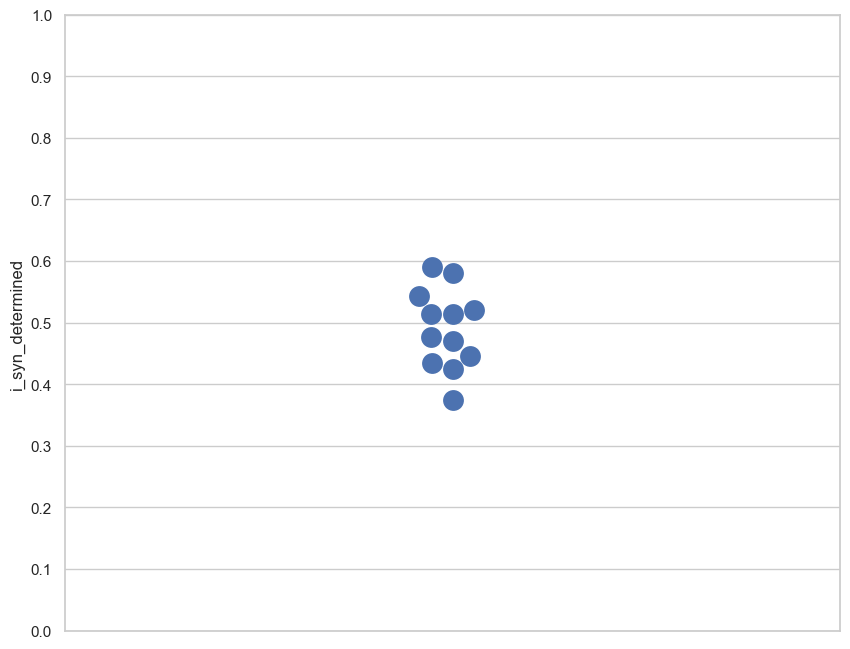

In [21]:
#FIGURE 3.e
#Swarm plot
import seaborn as sns
sns.set(style="whitegrid")
#tips = sns.load_dataset("tips")
#ax = sns.swarmplot(x=tips["total_bill"])

f, ax = plt.subplots(figsize=(10,8))


ax = sns.swarmplot(y="i_syn_determined",
                   data=synapse_table_percentage,
                  size=15)


ax.set(ylim=(0, 1), yticks=np.arange(0, 1.1 , 0.1))



plt.savefig('Fig3e_synapses_revision.eps')

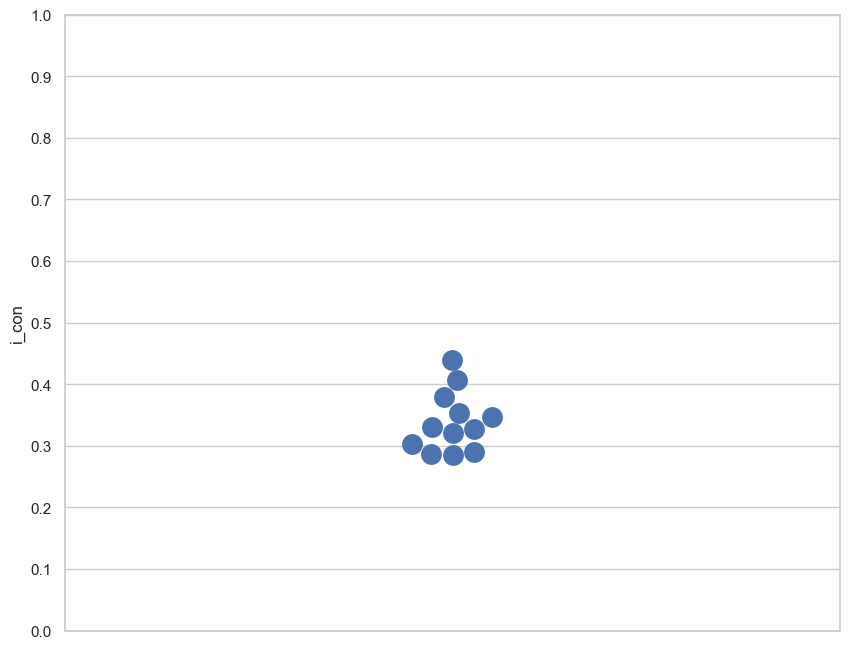

In [22]:
#FIGURE 3.f
#Swarm plot
import seaborn as sns
sns.set(style="whitegrid")
#tips = sns.load_dataset("tips")
#ax = sns.swarmplot(x=tips["total_bill"])

f, ax = plt.subplots(figsize=(10,8))


ax = sns.swarmplot(y="i_con",
                   data=synapse_table_percentage,
                  size=15)

ax.set(ylim=(0, 1))
ax.set(ylim=(0, 1), yticks=np.arange(0, 1.1 , 0.1))




plt.savefig('Fig3f_synapses_revision.eps')

In [23]:
#ANALYSIS - FIGURE 3.g-h

np.seterr(divide='ignore', invalid='ignore')

percentage = []
values = []

#IDs of presynaptic PT neurons
pre_soma_IDs = All_neurons_rootID


for ii,pre_soma_ID in enumerate(pre_soma_IDs):        
        
   
    stat_values={

                    'ID': pre_soma_ID,
                    'local_area': synapse_table[synapse_table['pre_pt_root_id'] == 
                                                     pre_soma_ID]['pre_soma_area'].unique()[0],
                  
                    #SYNAPSES
        
                    #V1
                    
                    'all_total_syn#': len(synapse_table[ (synapse_table['pre_pt_root_id'] == pre_soma_ID)]),
        
                    'NO_AREA_total_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                                            pd.isnull(synapse_table['post_soma_area'])]),
                     
                    'V1_total_syn#': len(synapse_table[ (synapse_table['post_soma_area'] == 'v1') &
                                                    (synapse_table['pre_pt_root_id'] == pre_soma_ID)]),                
                    
                    'V1_i_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'inhibitory') &
                                                   (synapse_table['post_soma_area'] == 'v1')]),
                   
        
                    'V1_e_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'excitatory') &
                                                   (synapse_table['post_soma_area'] == 'v1')]),
        
                    
                    'V1_Undetermined_class_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_class'] == 'Unsure') |
                                      pd.isnull(synapse_table['consensus_class'])) &
                                                                    (synapse_table['post_soma_area'] == 'v1')]),
        

        
                    #HVA
                    'HVA_total_syn#': len(synapse_table[ (synapse_table['post_soma_area'] == 'hva') &
                                                    (synapse_table['pre_pt_root_id'] == pre_soma_ID)]),
                    
                    'HVA_i_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'inhibitory') &
                                                   (synapse_table['post_soma_area'] == 'hva')]),
        
                    'HVA_e_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     (synapse_table['consensus_class'] == 'excitatory') &
                                                   (synapse_table['post_soma_area'] == 'hva')]),
        
                    'HVA_Undetermined_class_syn#': len(synapse_table[(synapse_table['pre_pt_root_id'] == pre_soma_ID) &
                                     ((synapse_table['consensus_class'] == 'Unsure') |
                                      pd.isnull(synapse_table['consensus_class'])) &
                                                                    (synapse_table['post_soma_area'] == 'hva')]),
                    
                   
        
        
    }
    values.append(stat_values)
    
    #print(stat_values['HVA_total_syn#'])
    if stat_values['HVA_total_syn#'] > 10:
        
        local_area = synapse_table[synapse_table['pre_pt_root_id'] == 
                                                         pre_soma_ID]['pre_soma_area'].unique()[0]
        if local_area == ('v1'):
            #print('aqui')

            stat_percentage={

                        'ID': pre_soma_ID,
                        'local_area': synapse_table[synapse_table['pre_pt_root_id'] == 
                                                         pre_soma_ID]['pre_soma_area'].unique()[0],

                        #SYNAPSES

                        #V1

                        'location': 'local',
                        'i_syn': stat_values['V1_i_syn#'] / stat_values['V1_total_syn#'],
                        'e_syn': stat_values['V1_e_syn#'] / stat_values['V1_total_syn#'],
                        'Undetermined_class_syn': stat_values['V1_Undetermined_class_syn#'] / stat_values['V1_total_syn#'],
            }
            percentage.append(stat_percentage)

            if stat_values['HVA_total_syn#'] > 0:
                stat_percentage={

                        'ID': pre_soma_ID,
                        'local_area': synapse_table[synapse_table['pre_pt_root_id'] == 
                                                         pre_soma_ID]['pre_soma_area'].unique()[0],

                        #SYNAPSES

                        #HVA
                        'location': 'inter-areal',
                        'i_syn': stat_values['HVA_i_syn#'] / stat_values['HVA_total_syn#'],
                        'e_syn': stat_values['HVA_e_syn#'] / stat_values['HVA_total_syn#'],
                        'Undetermined_class_syn': stat_values['HVA_Undetermined_class_syn#'] / stat_values['HVA_total_syn#'],
                }
                percentage.append(stat_percentage)
            else:
                stat_percentage={

                        'ID': pre_soma_ID,
                        'local_area': synapse_table[synapse_table['pre_pt_root_id'] == 
                                                         pre_soma_ID]['pre_soma_area'].unique()[0],

                        #SYNAPSES

                        #HVA
                        'location': 'inter-areal',
                        'i_syn': stat_values['HVA_i_syn#'],
                        'e_syn': stat_values['HVA_e_syn#'],
                        'Undetermined_class_syn': stat_values['HVA_Undetermined_class_syn#'],
                }
                percentage.append(stat_percentage)


        else:       
            stat_percentage={

                        'ID': pre_soma_ID,
                        'local_area': synapse_table[synapse_table['pre_pt_root_id'] == 
                                                         pre_soma_ID]['pre_soma_area'].unique()[0],

                        #SYNAPSES

                        #V1

                        'location': 'inter-areal',
                        'i_syn': stat_values['V1_i_syn#'] / stat_values['V1_total_syn#'],
                        'e_syn': stat_values['V1_e_syn#'] / stat_values['V1_total_syn#'],
                        'Undetermined_class_syn': stat_values['V1_Undetermined_class_syn#'] / stat_values['V1_total_syn#'],
            }
            percentage.append(stat_percentage)

            stat_percentage={

                        'ID': pre_soma_ID,
                        'local_area': synapse_table[synapse_table['pre_pt_root_id'] == 
                                                         pre_soma_ID]['pre_soma_area'].unique()[0],

                        #SYNAPSES

                        #HVA
                        'location': 'local',
                        'i_syn': stat_values['HVA_i_syn#'] / stat_values['HVA_total_syn#'],
                        'e_syn': stat_values['HVA_e_syn#'] / stat_values['HVA_total_syn#'],
                        'Undetermined_class_syn': stat_values['HVA_Undetermined_class_syn#'] / stat_values['HVA_total_syn#'],
            }
            percentage.append(stat_percentage)

synapse_area_table_values = pd.DataFrame(values)
synapse_area_table_percentage = pd.DataFrame(percentage)


#stats_type.append(stat)   


In [ ]:
#PLOT - Figure 3.g and h

import seaborn as sns
import matplotlib.pyplot as plt


#INDIVIDUAL CELLS

# Create a pointplot using Seaborn
sns.pointplot(x="location", y="i_syn", hue="ID", data=synapse_area_table_percentage)

# Set the plot title
plt.title("Individual neurons")

#save figure
plt.savefig('Fig3g_interareal_neurons_revision.eps')


# Show the plot
plt.show()


#CELLS GROUPED BY AREA OF THE SOMA

# Create a pointplot using Seaborn
sns.pointplot(x="location", y="i_syn", hue="local_area", data=synapse_area_table_percentage)

# Set the plot title
plt.title("Area of soma location")

#save figure
plt.savefig('Fig3g_interareal_areas_revision.eps')

# Show the plot
plt.show()


#ALL CELLS

# Create a pointplot using Seaborn
sns.pointplot(x="location", y="i_syn", data=synapse_area_table_percentage)

# Set the plot title
plt.title("Area of soma location")

#save figure
plt.savefig('Fig3g_interareal_all_revision.eps')


# Show the plot
plt.show()


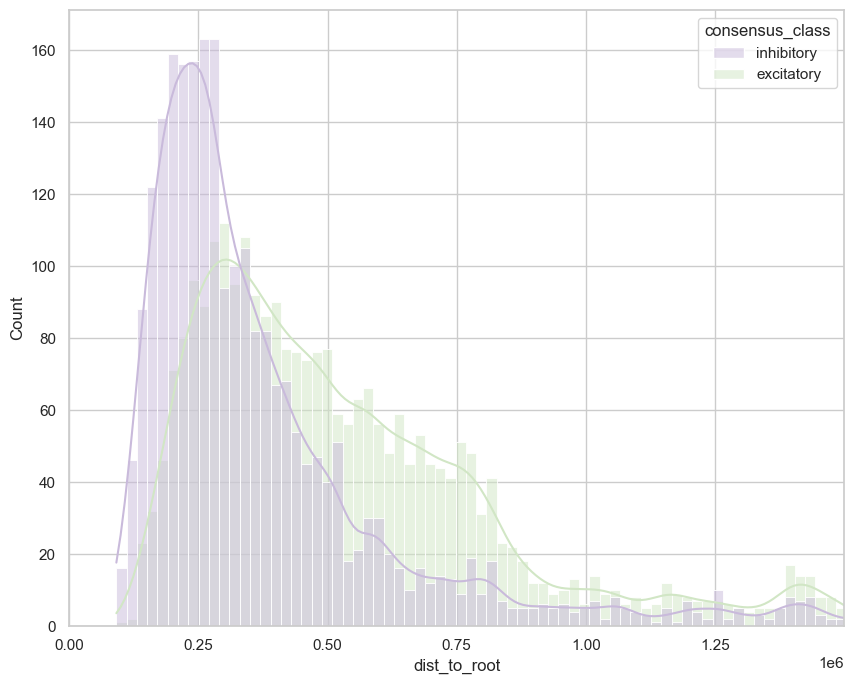

In [24]:
# FIGURE 3.i
import seaborn as sns

synapse_table_E_I = synapse_table[(synapse_table['consensus_class'] == 'excitatory') |
                                  (synapse_table['consensus_class'] == 'inhibitory')
                                 ]


f, ax = plt.subplots(figsize=(10,8))

kde_dict = {
            'bw_adjust' : 0.5,
            
}

#sns.histplot(synapse_table_NP_ET,
#            x="size" , hue = 'consensus_subclass', kde = True, kde_kws = kde_dict, fill=False, binwidth=50000, element="step")

#sns.histplot(synapse_table_E_I,
#            x="dist_to_root" , hue = 'consensus_class',kde = True, kde_kws = kde_dict, binwidth=20000 )

# Define a custom color palette
custom_palette = ['#c9badb','#d1e6c5']  # Converted RGB colors

# Create the histplot with the specified custom colors
sns.histplot(synapse_table_E_I,
             x="dist_to_root",
             hue="consensus_class",
             kde=True,
             kde_kws=kde_dict,
             binwidth=20000,
             palette=custom_palette)  # Apply custom colors


ax.set(xlim=(0, 1500000))#, xticks=np.arange(0, 1600000 , 100000))
ax.set_xticks(np.arange(0, 1500000 , 250000))
#ax.set(xlim=(0, 50000))

plt.savefig('Fig3i_path_length_revision.eps')


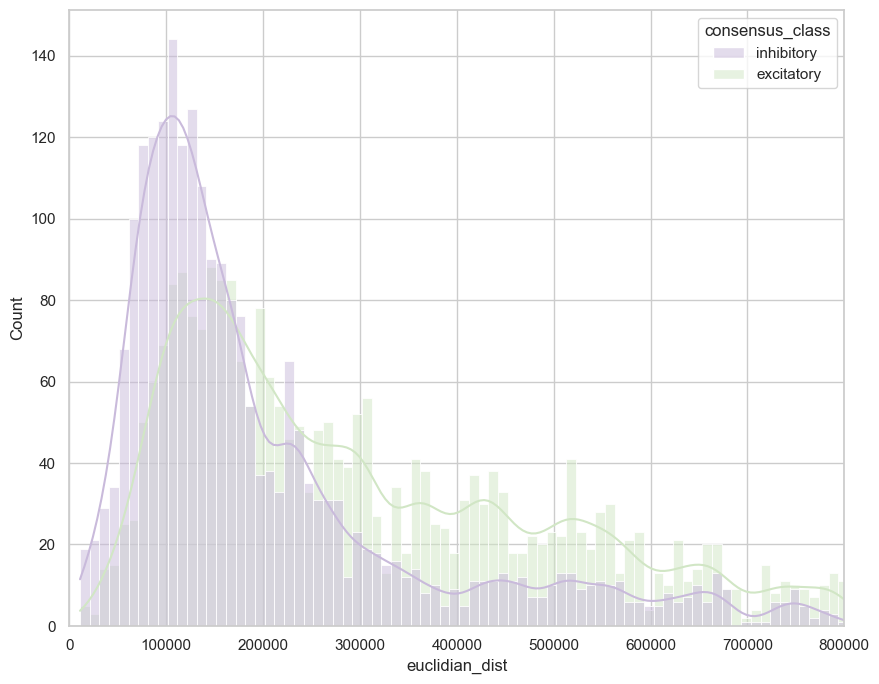

In [25]:
# FIGURE 3.k
import seaborn as sns


def euclidian_distance(row):
    if row['num_soma'] == 1:
          
        #print(row['pre_soma_pt'])
        x_pre = row['pre_soma_pt'][0] * 4
        y_pre = row['pre_soma_pt'][1] * 4
        z_pre = row['pre_soma_pt'][2] * 40
        
        
        #post-synaptic neuron soma
        #x_post = row['post_soma_pt'][0] * 4
        #y_post = row['post_soma_pt'][1] * 4
        #z_post = row['post_soma_pt'][2] * 40
        
        #synapse location
        x_post = row['ctr_pt_position'][0] * 4
        y_post = row['ctr_pt_position'][1] * 4
        z_post = row['ctr_pt_position'][2] * 40
 
        
        
        
        #print(row['pre_pt_position']-row['post_pt_position'])
        #print(row['pre_pt_position'])
        return np.linalg.norm(np.array([x_pre, y_pre, z_pre])-np.array([x_post, y_post, z_post]))
        #return np.linalg.norm(row['pre_pt_position']-row['post_pt_position'])
        
    else:
        return None

synapse_table['euclidian_dist'] = synapse_table.apply(euclidian_distance, axis=1)


synapse_table_E_I = synapse_table[(synapse_table['consensus_class'] == 'excitatory') |
                                  (synapse_table['consensus_class'] == 'inhibitory')
                                 ]


f, ax = plt.subplots(figsize=(10,8))

kde_dict = {
            'bw_adjust' : 0.5,
            
}

# Define a custom color palette
custom_palette = ['#c9badb','#d1e6c5']  # Converted RGB colors

#sns.histplot(synapse_table_NP_ET,
#            x="size" , hue = 'consensus_subclass', kde = True, kde_kws = kde_dict, fill=False, binwidth=50000, element="step")

sns.histplot(synapse_table_E_I,
            x="euclidian_dist" , hue = 'consensus_class',kde = True, kde_kws = kde_dict, binwidth=10000,
            palette=custom_palette)


ax.set(xlim=(0, 800000))

plt.savefig('Fig3k_euclidean_length_revision.eps')

In [26]:
# FIGURES 3.j and 3.l

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

raw_df = pd.read_feather("ET_extended_synapse_table_revision.feather")


#pre-synaptic neurons and post synaptic cell subclasses

studied_nuc_ids = {266839, 589294, 303216, 232635, 494888, 495010, 526436, 302951,
       267033, 267029, 527784, 337966}

synapse_table = raw_df[raw_df["pre_nucleus_id"].isin(studied_nuc_ids)]

#histogram metrics

max_hist_dist = 2_000_000
euc_dist_step = 100 * 1000
path_dist_step = 100 * 1000

#cache_dir = "../data/"
#results_dir = os.path.join(cache_dir, "results", "dendrite-clean-subclass")

#check data inclusion
unplotted = synapse_table[synapse_table["dist_to_root"] > max_hist_dist]
if len(unplotted) > 0:
    print("Some data is not captured by the histogram")


# define euc_dist_to_root column
resolution = np.array([4., 4., 40.])

def vx_to_nm(point):
    return point * resolution

ctr_locs = np.stack(synapse_table["ctr_pt_position"].apply(vx_to_nm).values)
#soma_locs = np.stack(synapse_table["pre_pt_position"].apply(vx_to_nm).values)

soma_locs = np.stack(synapse_table["pre_soma_pt"].apply(vx_to_nm).values)
synapse_table["euc_dist_to_root"] = np.sqrt(np.sum((ctr_locs - soma_locs)**2, axis=1)) #* 1000  # in nm

# rename column
synapse_table["path_dist_to_root"] = synapse_table["dist_to_root"]
synapse_table[["path_dist_to_root", "euc_dist_to_root"]]


# Create a dictionary called 'syn_dfs' with the key "inh" and a DataFrame containing inhibitory synapses.
# It filters the 'synapse_table' DataFrame where the 'consensus_class' column is equal to "inhibitory".
syn_dfs = {"inh": synapse_table[synapse_table["consensus_class"] == "inhibitory"]}
syn_dfs["exc"] = synapse_table[synapse_table["consensus_class"] == "excitatory"]


# Determine whether to use counts (False) or density (True) for the histogram
density = False

# Define bin edges for path distance
path_bin_edges = np.arange(0, max_hist_dist, path_dist_step)

# Calculate bin centers for path distance
path_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2

# Create a dictionary to store histograms of counts of each cell type by distance along the axon
path_hists = dict()

# Loop through each cell type in the 'syn_dfs' dictionary
for cell_type in syn_dfs:
    # Calculate the histogram of path distances for the current cell type
    # and store only the counts (not the bin edges) in the 'path_hists' dictionary
    path_hists[cell_type] = np.histogram(syn_dfs[cell_type]["path_dist_to_root"], bins=path_bin_edges, density=density)[0]

# Define bin edges for Euclidean distance
euc_bin_edges = np.arange(0, max_hist_dist, euc_dist_step)

# Calculate bin centers for Euclidean distance
euc_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2

# Create a dictionary to store histograms of counts of each cell type by distance along the axon
euc_hists = dict()

# Loop through each cell type in the 'syn_dfs' dictionary
for cell_type in syn_dfs:
    # Calculate the histogram of Euclidean distances for the current cell type
    # and store only the counts (not the bin edges) in the 'euc_hists' dictionary
    euc_hists[cell_type] = np.histogram(syn_dfs[cell_type]["euc_dist_to_root"], bins=euc_bin_edges, density=density)[0]


In [27]:
# FIGURES 3.j and 3.l

# Continuously moving bucket to calculate synapse density of each type
# This implementation may be slower, but it's functional
# A more efficient approach might involve looping over synapses and incrementing counters directly

# Number of steps for the moving bucket method
nsteps = 1000

# Define the bin locations and step size for Euclidean distance
euc_bin_locs = np.linspace(euc_dist_step / 2, max_hist_dist - euc_dist_step / 2, nsteps)
step_size = max_hist_dist / nsteps

# Define the bin locations and step size for path distance
path_bin_locs = np.linspace(path_dist_step / 2, max_hist_dist - path_dist_step / 2, nsteps)

# Create dictionaries to store Euclidean and path densities for each cell type
euc_densities = dict([(cell_type, np.zeros(nsteps)) for cell_type in syn_dfs])
path_densities = dict([(cell_type, np.zeros(nsteps)) for cell_type in syn_dfs])

# Loop through each step
for i in range(nsteps):
    # For Euclidean distance
    euc_c = euc_bin_locs[i]  # Get the current bin center
    euc_l = euc_c - euc_dist_step / 2  # Calculate the left bin edge
    euc_r = euc_c + euc_dist_step / 2  # Calculate the right bin edge
    for cell_type in syn_dfs:
        # Calculate the density within the current bin for the current cell type
        # by counting synapses that fall within the bin
        euc_densities[cell_type][i] = sum((euc_l < syn_dfs[cell_type]["euc_dist_to_root"]).values & (syn_dfs[cell_type]["euc_dist_to_root"] < euc_r).values) / euc_dist_step

    # For path distance
    path_c = path_bin_locs[i]  # Get the current bin center
    path_l = path_c - path_dist_step / 2  # Calculate the left bin edge
    path_r = path_c + path_dist_step / 2  # Calculate the right bin edge
    for cell_type in syn_dfs:
        # Calculate the density within the current bin for the current cell type
        # by counting synapses that fall within the bin
        path_densities[cell_type][i] = sum((path_l < syn_dfs[cell_type]["path_dist_to_root"]).values & (syn_dfs[cell_type]["path_dist_to_root"] < path_r).values) / path_dist_step

In [28]:
# FIGURES 3.j and 3.l

# Create a dictionary to store the proportion of synapses for each cell type by path distances
p_type_by_path_dists = dict()

# Calculate the total density of synapses by summing densities for all cell types
path_total_density = sum(path_densities[t] for t in path_densities)

# Loop through each cell type's path densities to calculate proportions
for cell_type in path_densities:
    # Calculate the proportion of synapses for the current cell type by dividing its density
    # by the total density across all cell types
    p_type_by_path_dists[cell_type] = path_densities[cell_type] / path_total_density

# Create a dictionary to store the proportion of synapses for each cell type by Euclidean distances
p_type_by_euc_dists = dict()

# Calculate the total density of synapses by summing densities for all cell types
euc_total_density = sum(euc_densities[t] for t in euc_densities)

# Loop through each cell type's Euclidean densities to calculate proportions
for cell_type in euc_densities:
    # Calculate the proportion of synapses for the current cell type by dividing its density
    # by the total density across all cell types
    p_type_by_euc_dists[cell_type] = euc_densities[cell_type] / euc_total_density

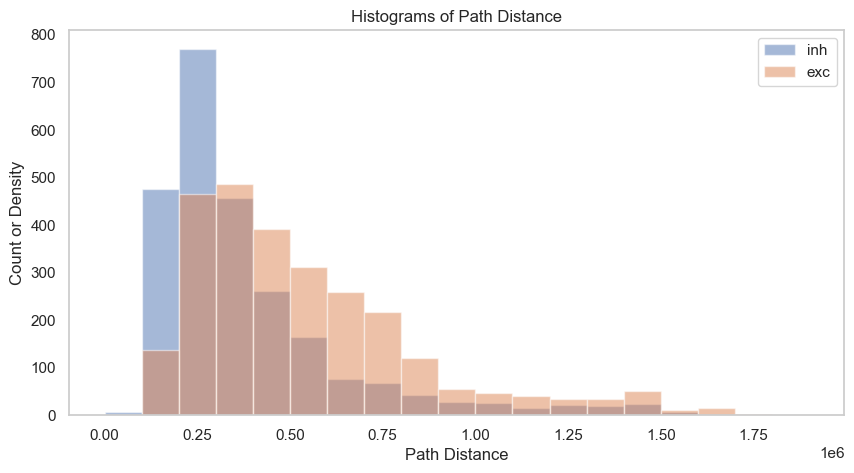

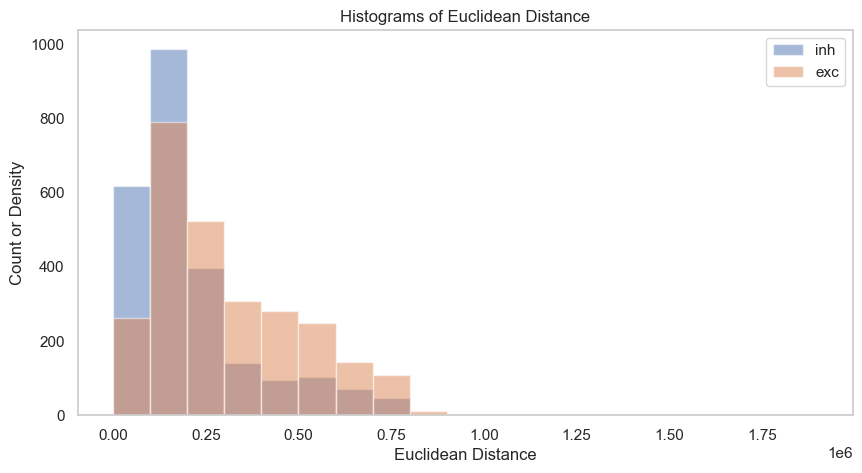

In [29]:
# FIGURES 3.j and 3.l

import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already calculated the path_hists and euc_hists dictionaries

# Plot histograms for path distance
plt.figure(figsize=(10, 5))
plt.title("Histograms of Path Distance")
for cell_type, hist in path_hists.items():
    plt.hist(path_bin_centers, bins=path_bin_edges, weights=hist, label=cell_type, alpha=0.5)

plt.xlabel("Path Distance")
plt.ylabel("Count or Density")
plt.legend()
plt.grid()
plt.show()

# Plot histograms for Euclidean distance
plt.figure(figsize=(10, 5))
plt.title("Histograms of Euclidean Distance")
for cell_type, hist in euc_hists.items():
    plt.hist(euc_bin_centers, bins=euc_bin_edges, weights=hist, label=cell_type, alpha=0.5)

plt.xlabel("Euclidean Distance")
plt.ylabel("Count or Density")
plt.legend()
plt.grid()
plt.show()

In [30]:
# FIGURES 3.j and 3.l

# path-length distance split by post-synaptice cell subclass
plot_prefix = "inh_together"
cell_types = ["inh"] + ["exc"]
plot_colors = ["indigo"] + ["lime"]# * len(exc_cell_types)
type_colors = dict(zip(cell_types, plot_colors))

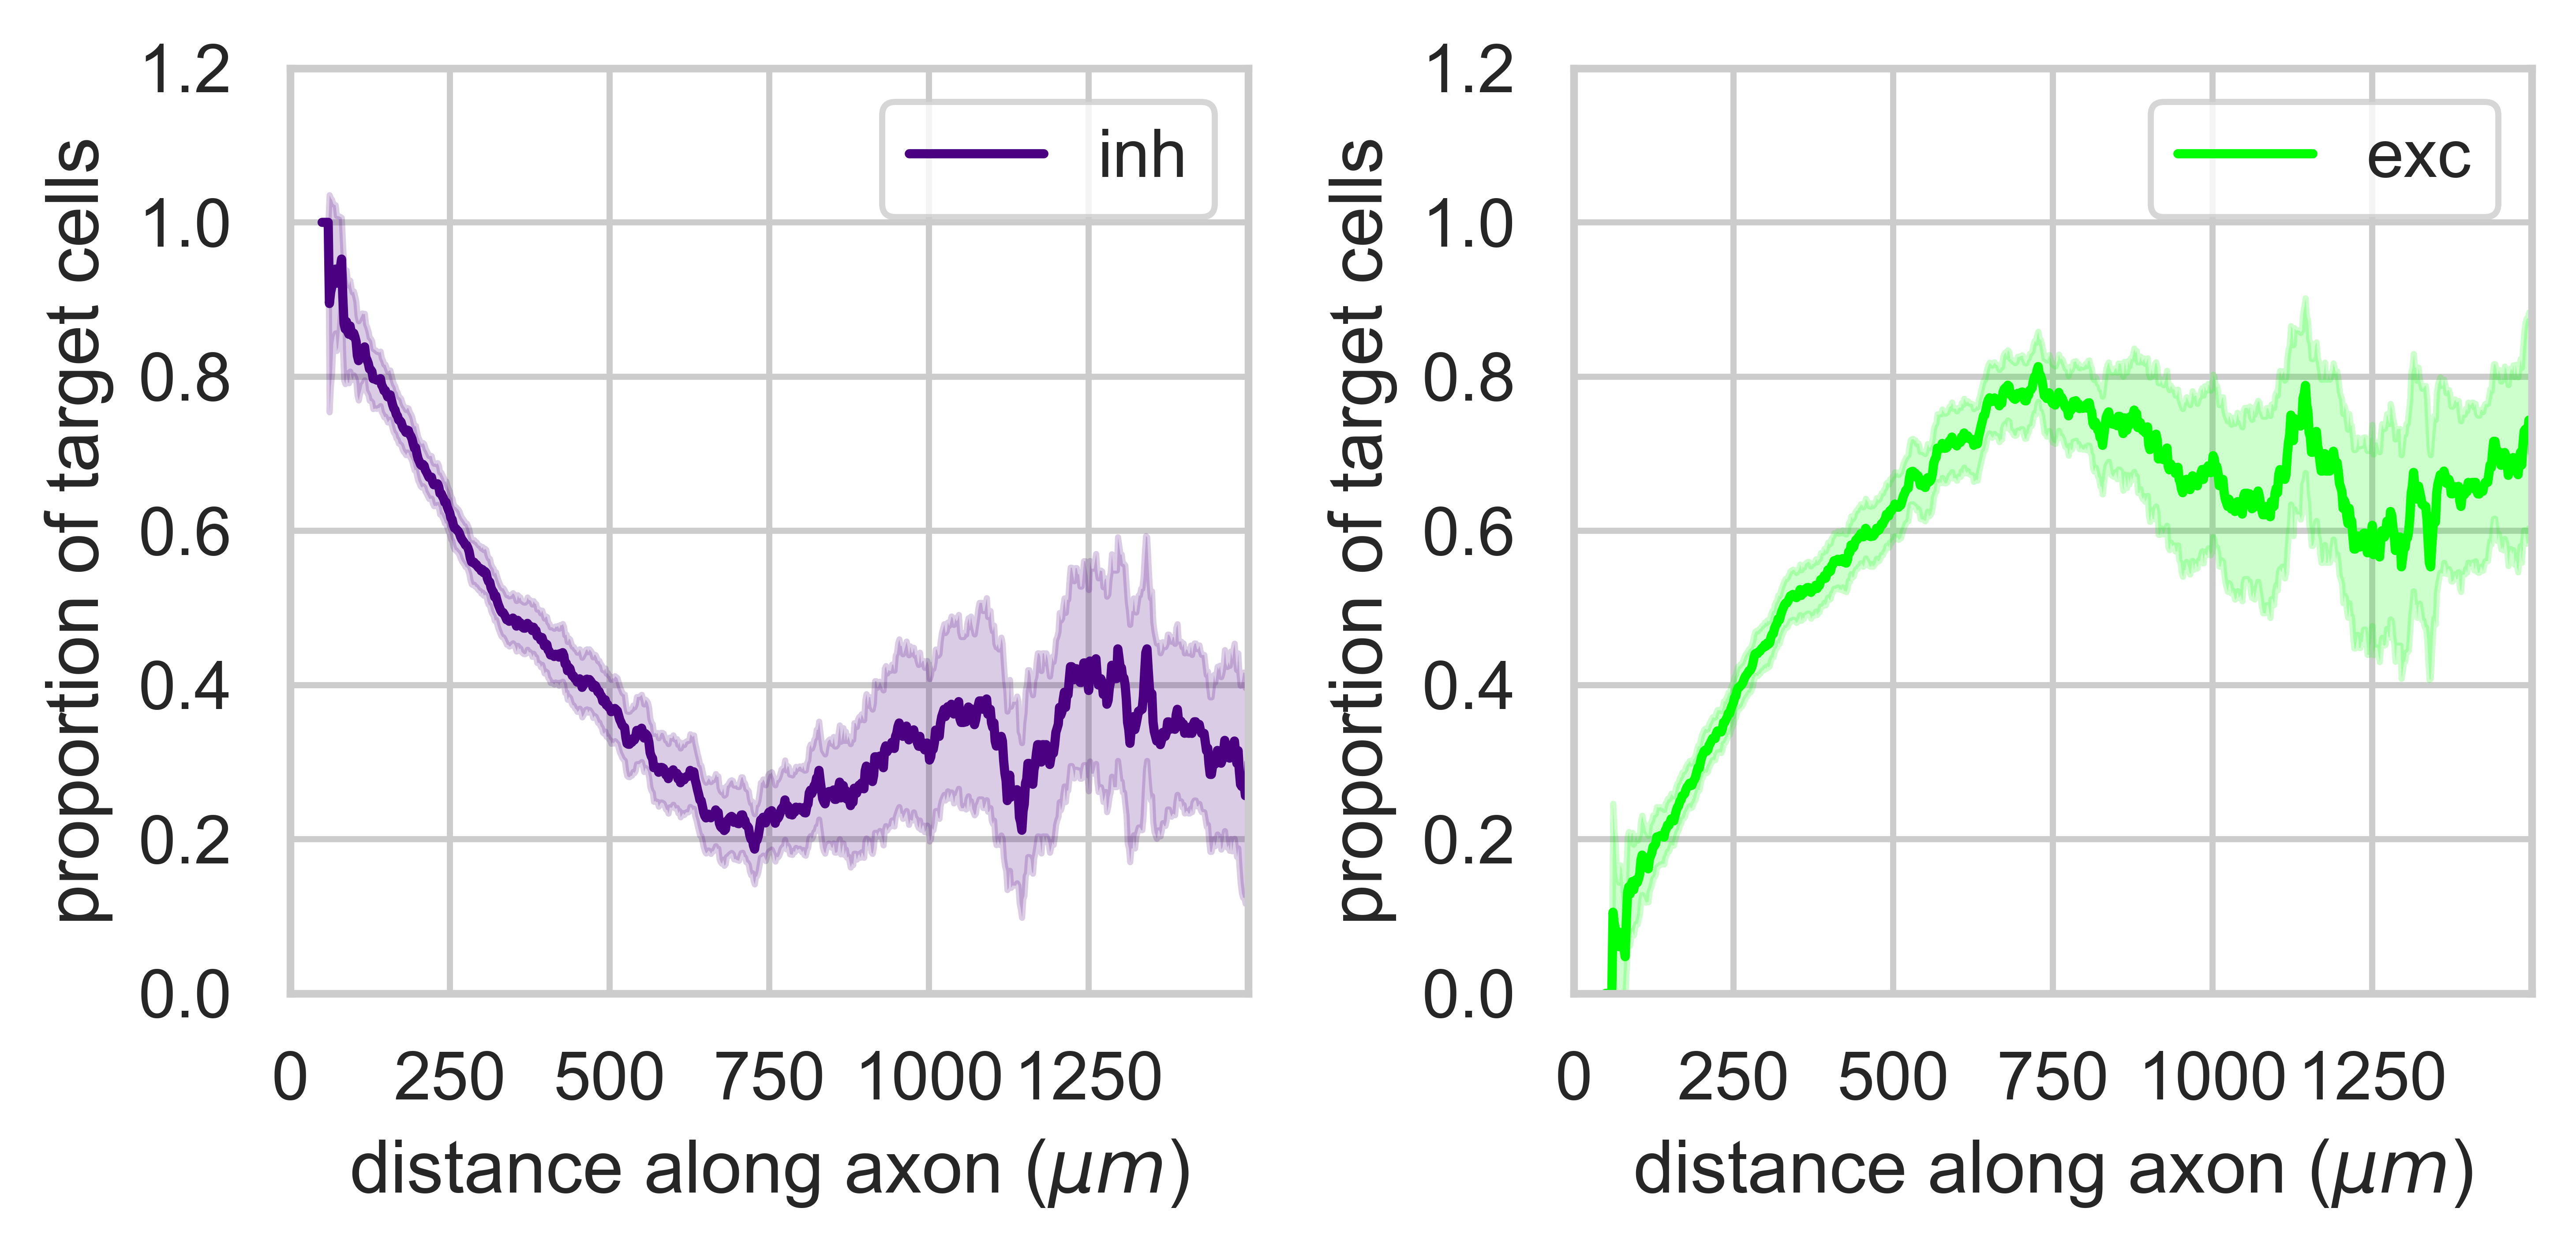

In [31]:
# FIGURES 3.j

fig, axes = plt.subplots(1, len(cell_types), figsize=(3 * len(cell_types), 3), dpi=1000)

for i, cell_type in enumerate(cell_types):
    p = p_type_by_path_dists[cell_type]
    axes[i].plot(path_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    std_hat = np.sqrt(p * (1 - p) / (path_dist_step * path_total_density))
    axes[i].fill_between(path_bin_locs/1000, p - 2 * std_hat, p + 2 * std_hat, color=type_colors[cell_type], alpha=0.2)
    axes[i].legend()
    axes[i].grid(True)
    axes[i].set_ylim((0, 1.2))
    #axes[i].set_xlim((0, max_hist_dist/1000))
    axes[i].set_xlim((0, 1500))
    axes[i].set_xticks(np.arange(0, 1500 , 250))
    axes[i].set_ylabel("proportion of target cells")
    axes[i].set_xlabel("distance along axon ($\mu m$)")
plt.tight_layout()

plt.savefig('Fig3j_path_length_fraction_revision.svg')

plt.show()


inh
exc
ping


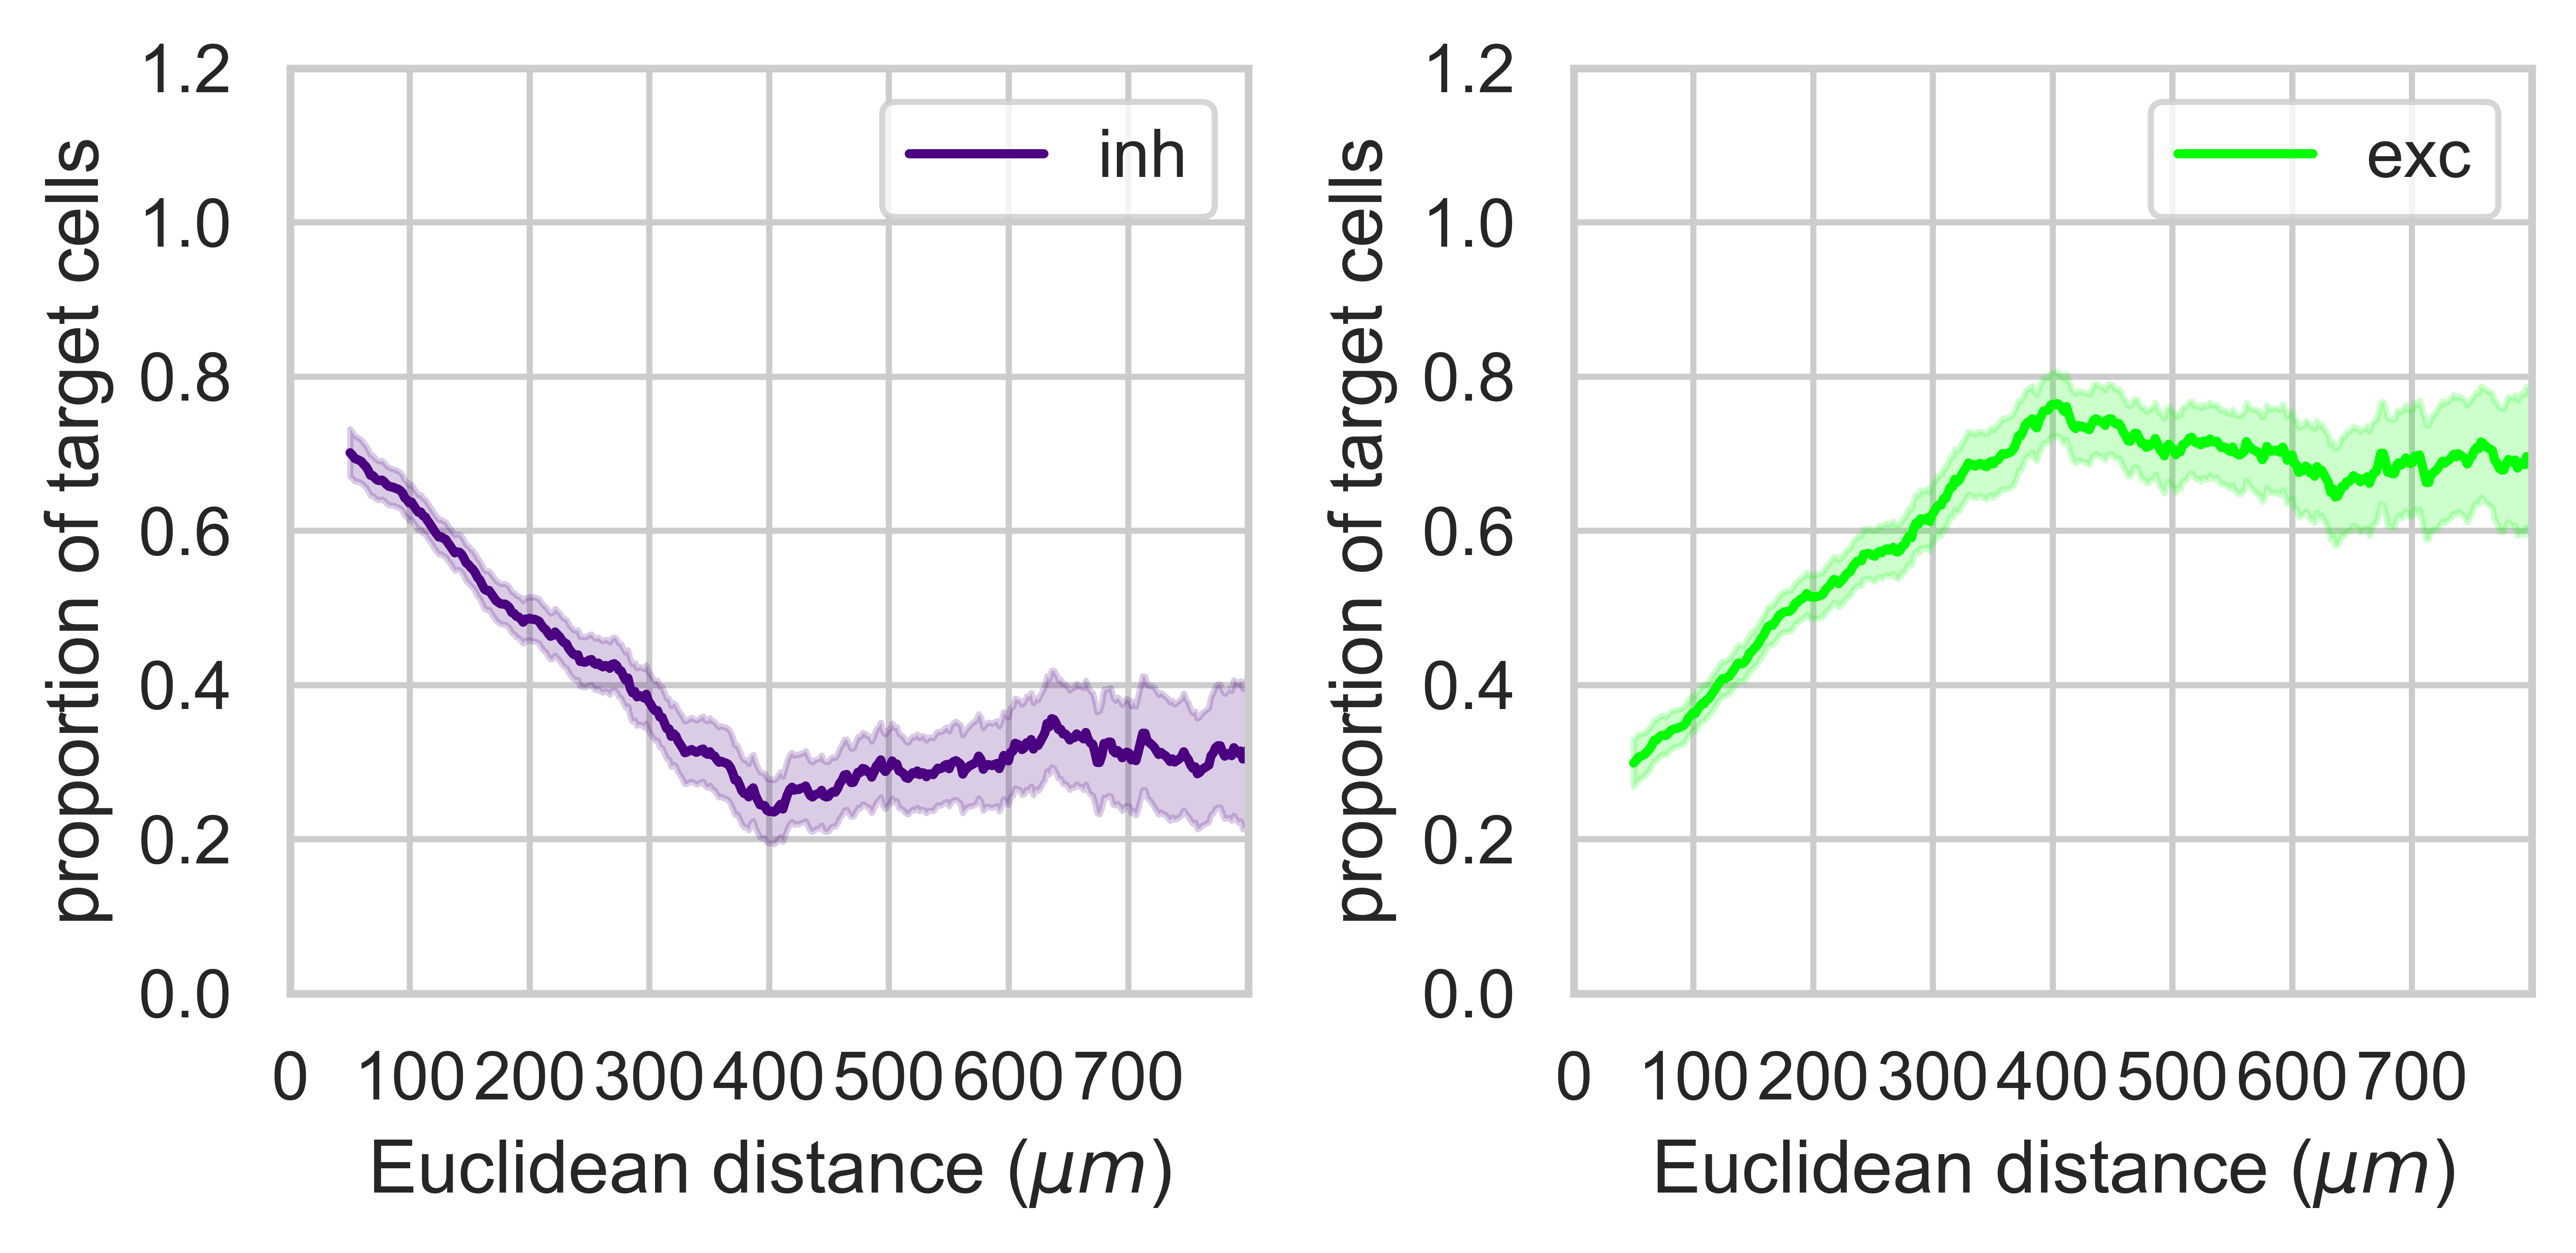

In [32]:
# FIGURES 3.l

# path-length distance split by post-synaptice cell subclass
fig, axes = plt.subplots(1, len(cell_types), figsize=(3 * len(cell_types), 3), dpi=1000)

for i, cell_type in enumerate(cell_types):
    print(cell_type)
    p = p_type_by_euc_dists[cell_type]
    axes[i].plot(euc_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    std_hat = np.sqrt(p * (1 - p) / (euc_dist_step * euc_total_density))
    axes[i].fill_between(euc_bin_locs/1000, p - 2 * std_hat, p + 2 * std_hat, color=type_colors[cell_type], alpha=0.2)
    axes[i].legend()
    axes[i].set_ylim((0, 1.2))
    axes[i].set_xlim((0, 800))
    axes[i].set_xticks(np.arange(0, 800 , 100))
    axes[i].set_ylabel("proportion of target cells")
    axes[i].set_xlabel("Euclidean distance ($\mu m$)")
    axes[i].grid(True)
plt.tight_layout()

print('ping')

#plt.show()
plt.savefig('Fig3l_euc_fraction_revision.svg')